In [ ]:
# Install if not already installed
!pip install geopandas osmnx folium matplotlib pandas

In [4]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import folium
import matplotlib.pyplot as plt

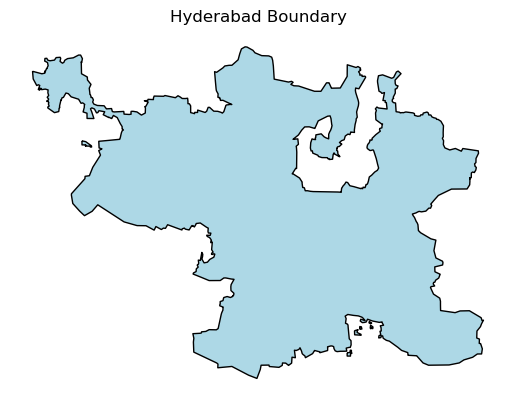

In [6]:
# Get Hyderabad boundary polygon
hyderabad = ox.geocode_to_gdf("Hyderabad, India")
hyderabad = hyderabad.to_crs(epsg=4326)  # WGS84 for mapping

# Plot boundary
hyderabad.plot(edgecolor='black', facecolor='lightblue')
plt.title("Hyderabad Boundary")
plt.axis('off')
plt.show()

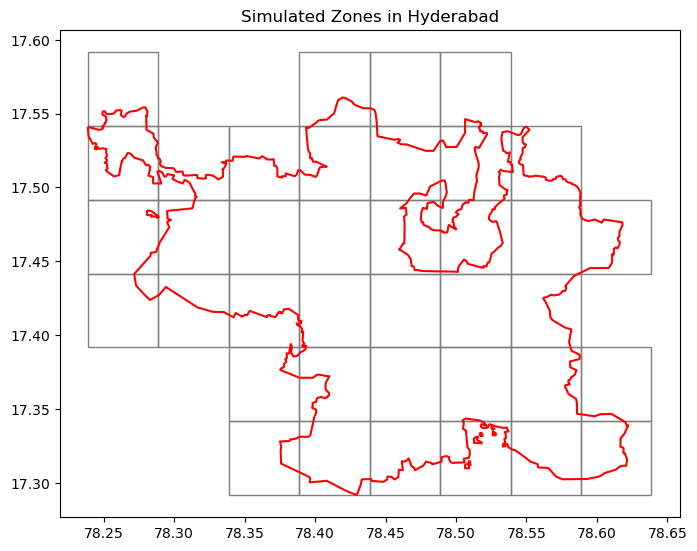

In [8]:
from shapely.geometry import box
import numpy as np

# Create a grid of square zones inside Hyderabad boundary
minx, miny, maxx, maxy = hyderabad.total_bounds
grid_size = 0.05  # degrees ~ 5km x 5km

grid_cells = []
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

for x in x_coords:
    for y in y_coords:
        cell = box(x, y, x + grid_size, y + grid_size)
        if cell.intersects(hyderabad.geometry[0]):
            grid_cells.append(cell)

zones = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:4326')

# Plot zones over city
fig, ax = plt.subplots(figsize=(8, 8))
zones.plot(ax=ax, facecolor='none', edgecolor='gray')
hyderabad.boundary.plot(ax=ax, color='red')
plt.title("Simulated Zones in Hyderabad")
plt.show()

In [10]:
import random

# Assign random population values
zones['population'] = [random.randint(1000, 5000) for _ in range(len(zones))]

# Energy assumption: kWh per person per year
kwh_per_person = 1200  # Example from BEE/NITI Aayog reports

# Calculate Residential Energy Demand
zones['res_energy_kwh'] = zones['population'] * kwh_per_person

zones[['population', 'res_energy_kwh']].head()

,population,res_energy_kwh
0,2790,3348000
1,3194,3832800
2,2893,3471600
3,4902,5882400
4,1708,2049600


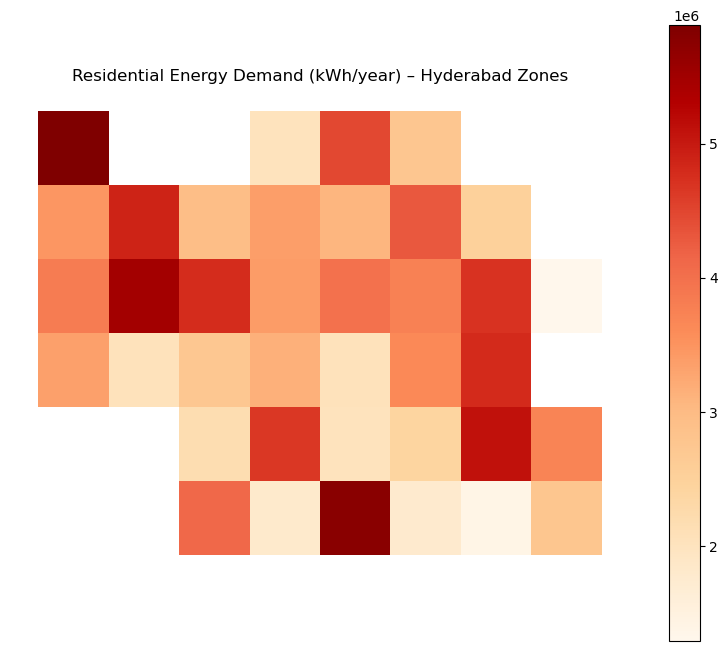

In [12]:
# Plot choropleth of energy demand
zones.plot(column='res_energy_kwh', cmap='OrRd', legend=True, figsize=(10, 8))
plt.title("Residential Energy Demand (kWh/year) – Hyderabad Zones")
plt.axis('off')
plt.show()

In [16]:
# Make sure we reset the index so we have an 'id' column
zones_folium = zones.copy().reset_index()  # now 'index' becomes a column
zones_folium = zones_folium.to_crs(epsg=4326)  # Ensure correct CRS for Folium

# Initialize Folium map
m = folium.Map(location=[17.385, 78.4867], zoom_start=10, tiles="cartodbpositron")

# Add Choropleth layer
folium.Choropleth(
    geo_data=zones_folium,
    name="Residential Energy Demand",
    data=zones_folium,
    columns=["index", "res_energy_kwh"],  # use reset index
    key_on="feature.properties.index",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Residential Energy Demand (kWh/year)"
).add_to(m)

# Optional: Add layer control
folium.LayerControl().add_to(m)

m

In [18]:
# Simulate commercial area (m²) per zone
zones['commercial_area'] = [random.randint(5000, 20000) for _ in range(len(zones))]

# Assumed energy intensity
kwh_per_m2_commercial = 250

# Estimate commercial energy demand
zones['comm_energy_kwh'] = zones['commercial_area'] * kwh_per_m2_commercial

In [20]:
# Simulate road length per zone (in km)
zones['road_km'] = [random.uniform(1, 10) for _ in range(len(zones))]

# Assumed lighting intensity: 25 kWh per km per day × 365
lighting_kwh_per_km = 25 * 365

# Estimate annual lighting energy demand
zones['light_energy_kwh'] = zones['road_km'] * lighting_kwh_per_km

In [22]:
zones['total_kwh'] = zones['res_energy_kwh'] + zones['comm_energy_kwh'] + zones['light_energy_kwh']
zones[['res_energy_kwh', 'comm_energy_kwh', 'light_energy_kwh', 'total_kwh']].head()

,res_energy_kwh,comm_energy_kwh,light_energy_kwh,total_kwh
0,3348000,2391000,57044.758255,5.796045e+06
1,3832800,2604500,50399.393320,6.487699e+06
2,3471600,4038500,51741.323914,7.561841e+06
3,5882400,4259750,24735.417518,1.016689e+07
4,2049600,3649750,25936.354569,5.725286e+06


In [24]:
def simulate_scenario(pop_growth=0.2, solar_offset=0.3):
    # Copy base
    sim = zones.copy()

    # Updated residential population
    sim['new_population'] = sim['population'] * (1 + pop_growth)
    sim['new_res_kwh'] = sim['new_population'] * kwh_per_person

    # Apply solar offset
    sim['solar_kwh'] = sim['new_res_kwh'] * solar_offset
    sim['residual_res_kwh'] = sim['new_res_kwh'] - sim['solar_kwh']

    # Recalculate total
    sim['new_total_kwh'] = sim['residual_res_kwh'] + sim['comm_energy_kwh'] + sim['light_energy_kwh']
    
    return sim

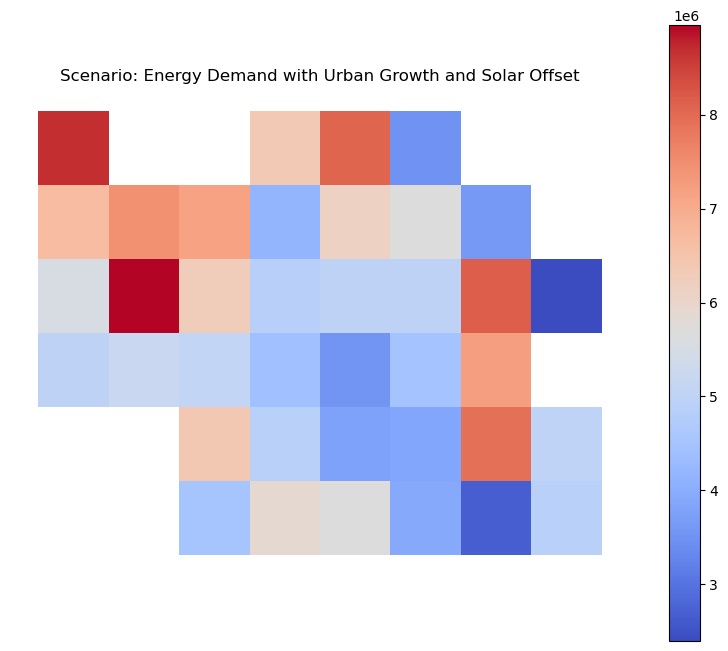

In [26]:
# Example: 25% population growth, 40% solar offset
scenario = simulate_scenario(pop_growth=0.25, solar_offset=0.4)

# Plot new total demand
scenario.plot(column='new_total_kwh', cmap='coolwarm', legend=True, figsize=(10, 8))
plt.title("Scenario: Energy Demand with Urban Growth and Solar Offset")
plt.axis('off')
plt.show()